# Анализ исторических данных о температуре

In [19]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('temperature_data.csv')

In [3]:
data.head()

,city,timestamp,temperature,season
0,New York,2010-01-01,-2.572540,winter
1,New York,2010-01-02,5.898166,winter
2,New York,2010-01-03,5.264936,winter
3,New York,2010-01-04,3.577332,winter
4,New York,2010-01-05,1.735268,winter


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.normalize()

In [6]:
data.isna().sum()

city           0
timestamp      0
temperature    0
season         0
dtype: int64

In [7]:
data.describe()

,timestamp,temperature
count,54750,54750.000000
mean,2014-12-30 12:00:00,18.301791
min,2010-01-01 00:00:00,-24.353913
25%,2012-07-01 00:00:00,11.133832
50%,2014-12-30 12:00:00,18.796332
75%,2017-06-30 00:00:00,26.146687
max,2019-12-29 00:00:00,57.024863
std,NaN,10.996794


In [8]:
data.describe(include='object')

,city,season
count,54750,54750
unique,15,4
top,New York,spring
freq,3650,13800


## Скользящее среднее

[Алгоритм вычисления простого скользящего среднего](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F#:~:text=.-,%D0%9F%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B5%20%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B5%D0%B5%20%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5,-%5B%D0%BF%D1%80%D0%B0%D0%B2%D0%B8%D1%82%D1%8C%20%7C)

Температуры для которых нельзя посчитать сглаженные значения с заданным окном (январь 2010) остаются неизменными.

In [9]:
def SMA(data, n):
    '''
    Вычесляет простое скользящее среднее для температуры из таблицы data c задынным окном n.
    Таблица должна быть отсортированна по дате.
    '''
    # Предобработка данных
    data_copy = data.copy()
    data_copy['smoothed_temperature'] = data_copy['temperature']
    
    # Подсчет сглаженной температуры для первой доступной даты
    first_value = data_copy.head(n)['temperature'].mean()
    first_index = data_copy.iloc[n - 1].name
    data_copy.loc[first_index, 'smoothed_temperature'] = first_value
    
    # Подготовка данных для вычисления сглаживающих значений по рекурентной формуле
    global prev_SMA
    
    prev_SMA = data_copy.loc[first_index]['smoothed_temperature']
    data_copy[f'temp_{n}_days_ago'] = data_copy['temperature'].shift(n)
    
    # Вычесление остальных сглаженных температур
    def recurrent_SMA(x):
        '''
        Функция для pd.DataFrame.apply: вычисляет сглаженную температуру по значениям текущего и предыдущего объекта.
        '''
        global prev_SMA
        
        x['smoothed_temperature'] = prev_SMA - x[f'temp_{n}_days_ago'] / n + x['temperature'] / n
        
        prev_SMA = x['smoothed_temperature']
        
        return x
    
    data_copy.iloc[n:] = data_copy.iloc[n:].apply(recurrent_SMA, axis=1)
    
    return data_copy['smoothed_temperature']

In [10]:
def temperature_SMA(data):
    for city in pd.unique(data['city']):
        sorted_data = data[data['city'] == city].sort_values('timestamp')
        smoothed_temperature = SMA(sorted_data, 30)
        data.loc[smoothed_temperature.index, 'smoothed_temperature'] = smoothed_temperature
        
temperature_SMA(data)

In [11]:
data

,city,timestamp,temperature,season,smoothed_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540
1,New York,2010-01-02,5.898166,winter,5.898166
2,New York,2010-01-03,5.264936,winter,5.264936
3,New York,2010-01-04,3.577332,winter,3.577332
4,New York,2010-01-05,1.735268,winter,1.735268
...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199
54746,Mexico City,2019-12-26,5.051404,winter,11.936984
54747,Mexico City,2019-12-27,9.463439,winter,11.698947
54748,Mexico City,2019-12-28,9.757999,winter,11.467487


In [12]:
data.describe()

,timestamp,temperature,smoothed_temperature
count,54750,54750.000000,54750.000000
mean,2014-12-30 12:00:00,18.301791,18.300746
min,2010-01-01 00:00:00,-24.353913,-22.670607
25%,2012-07-01 00:00:00,11.133832,12.098036
50%,2014-12-30 12:00:00,18.796332,18.593160
75%,2017-06-30 00:00:00,26.146687,25.773623
max,2019-12-29 00:00:00,57.024863,42.133612
std,NaN,10.996794,9.623177


Для построения графиков удалим строки с незглаженной температурой.

In [13]:
data.head(30)

,city,timestamp,temperature,season,smoothed_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540
1,New York,2010-01-02,5.898166,winter,5.898166
2,New York,2010-01-03,5.264936,winter,5.264936
3,New York,2010-01-04,3.577332,winter,3.577332
4,New York,2010-01-05,1.735268,winter,1.735268
5,New York,2010-01-06,1.339915,winter,1.339915
6,New York,2010-01-07,2.988776,winter,2.988776
7,New York,2010-01-08,0.058736,winter,0.058736
8,New York,2010-01-09,-2.910293,winter,-2.910293
9,New York,2010-01-10,2.576265,winter,2.576265


In [14]:
plot_data = None

for city in pd.unique(data['city']):
    plot_data = pd.concat([plot_data, data[data['city'] == city].iloc[29:]])

plot_data

,city,timestamp,temperature,season,smoothed_temperature
29,New York,2010-01-30,5.108875,winter,0.222941
30,New York,2010-01-31,0.452724,winter,0.323783
31,New York,2010-02-01,-0.826901,winter,0.099614
32,New York,2010-02-02,-7.961226,winter,-0.341258
33,New York,2010-02-03,1.517872,winter,-0.409906
...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199
54746,Mexico City,2019-12-26,5.051404,winter,11.936984
54747,Mexico City,2019-12-27,9.463439,winter,11.698947
54748,Mexico City,2019-12-28,9.757999,winter,11.467487


In [15]:
import matplotlib.pyplot as plt

def temperature_plot_1(city):
    '''
    Строит графики изменения температуры в течение года
    для заданного города.
    '''
    years = pd.unique(plot_data['timestamp'].dt.year)

    ncols = 3
    nrows = (len(years) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows))

    axes = axes.flatten()

    for i, year in enumerate(years):
        ax = axes[i]

        city_data = plot_data[(plot_data['city'] == city) & (plot_data['timestamp'].dt.year == year)]
        
        ax.plot(city_data['timestamp'], city_data['temperature'], label='temperature', color='blue', alpha=0.5)
        ax.plot(city_data['timestamp'], city_data['smoothed_temperature'], label='smoothed temperature', color='blue', alpha=1)

        ax.set_xlabel('date')
        ax.set_ylabel('t, C')
        ax.set_title(f'Moscow {year}')
        ax.grid(True)

        ax.legend()

    for i in range(len(years), len(axes)):
        fig.delaxes(axes[i])

    plt.show()


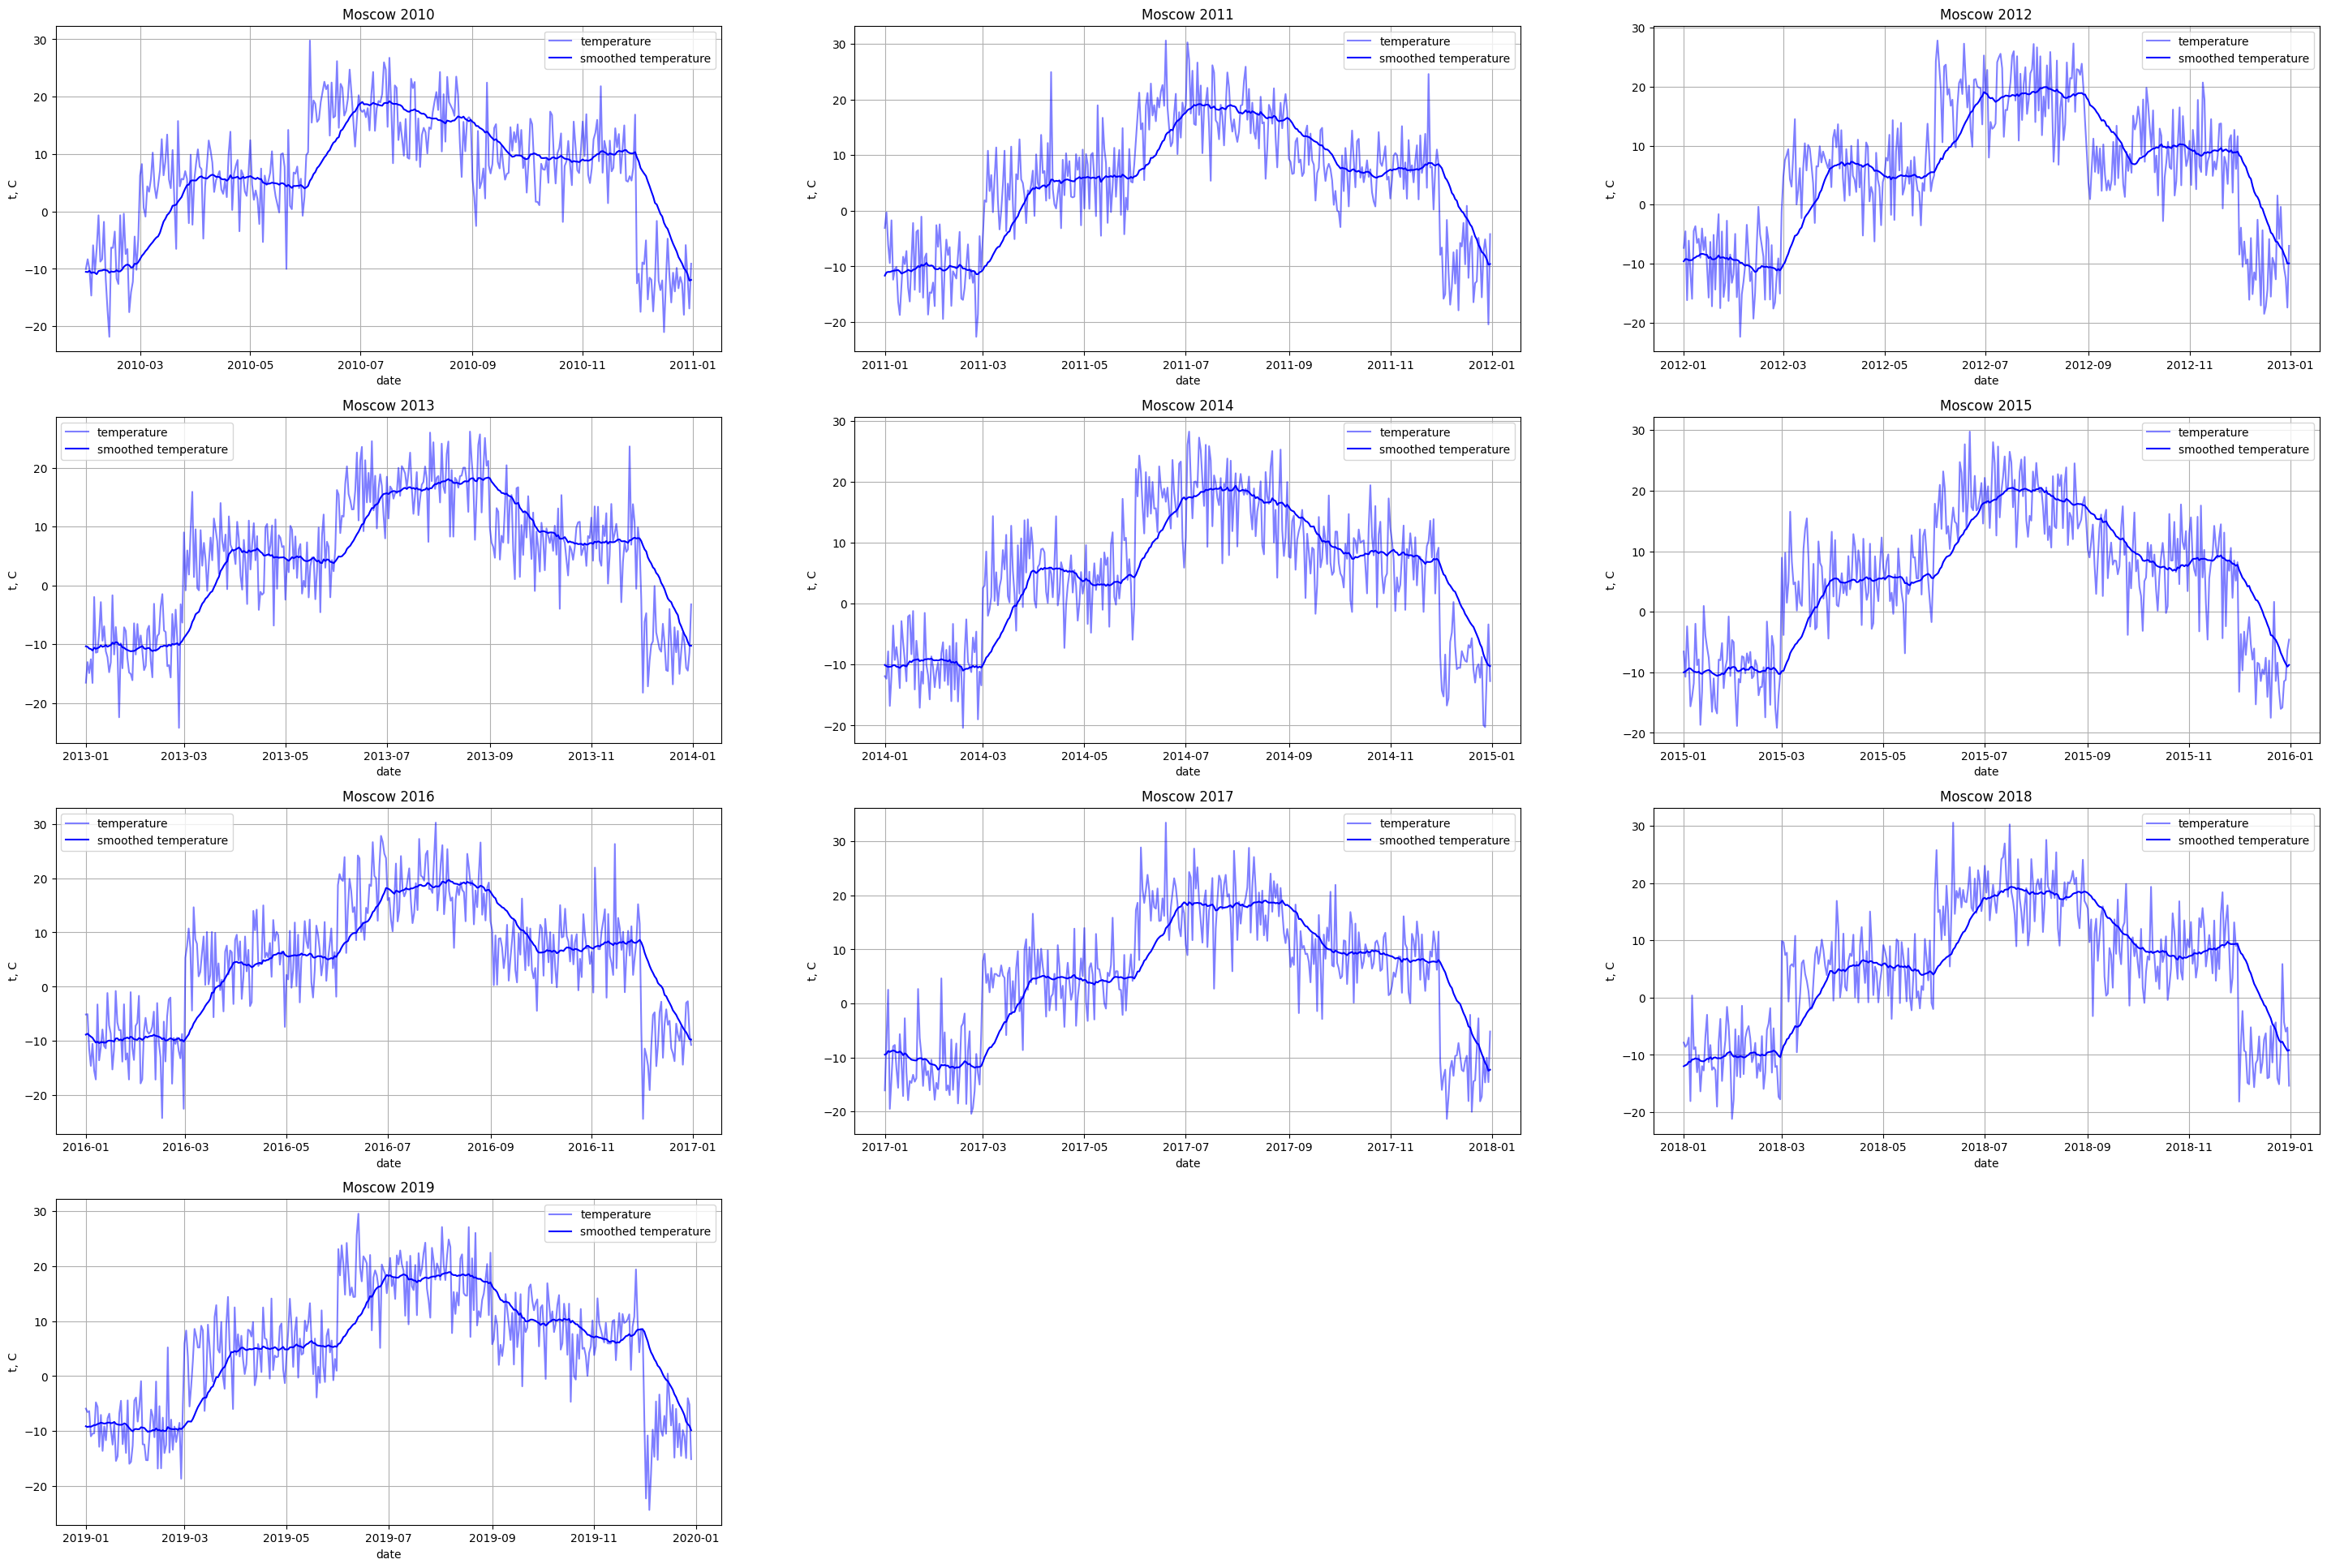

In [16]:
temperature_plot_1('Moscow')

In [17]:
def temperature_plot_2(city):
    city_data = plot_data[plot_data['city'] == city].copy()

    city_data['year'] = city_data['timestamp'].dt.year
    city_data['month'] = city_data['timestamp'].dt.month
    city_data['day_of_year'] = city_data['timestamp'].dt.dayofyear

    fig, ax = plt.subplots(figsize=(14, 7))

    for year in city_data['year'].unique():
        year_data = city_data[city_data['year'] == year]
        ax.plot(year_data['day_of_year'], year_data['smoothed_temperature'], label=str(year))

    month_starts = pd.date_range(start="2010-01-01", end="2010-12-31", freq="MS")
    month_labels = month_starts.strftime("%b")

    ax.set_xticks(month_starts.dayofyear)
    ax.set_xticklabels(month_labels)

    ax.set_xlabel('month')
    ax.set_ylabel('t,°C')
    ax.set_title(f'Dynamics of monthly temperature change, {city} 2010 - 2019')

    ax.legend(title='year', loc='upper right')

    ax.grid(True)

    plt.show()

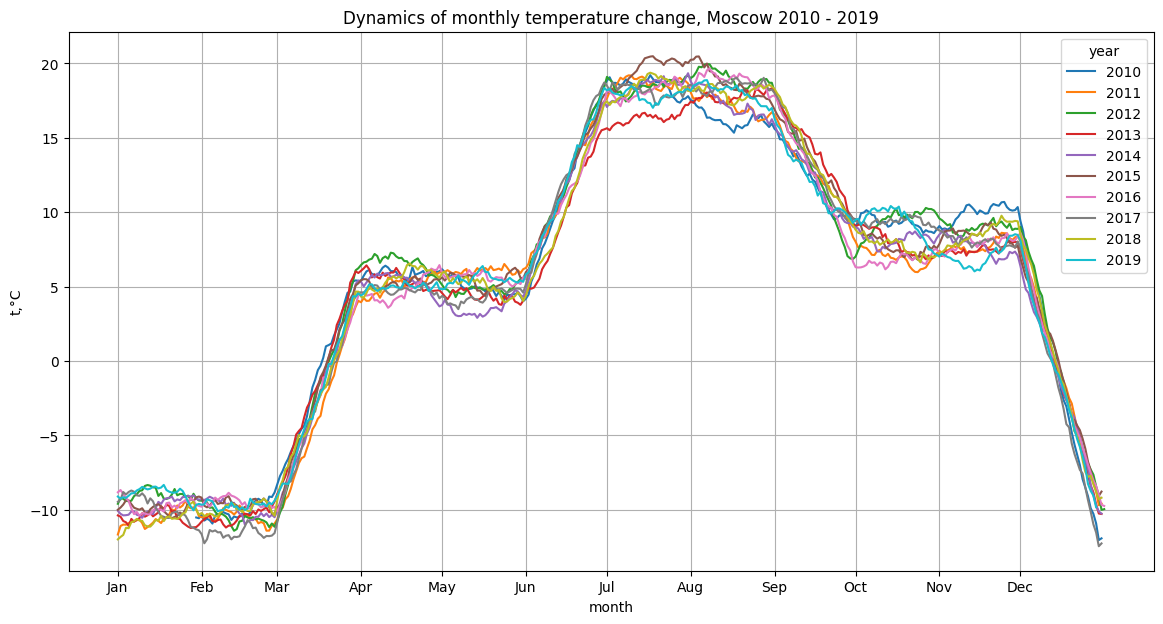

In [18]:
temperature_plot_2('Moscow')

## Средняя температура и стандартное отклонение

In [19]:
pd.pivot_table(data=data, values='smoothed_temperature', index=['city', 'season'], aggfunc=['mean', 'std'])

mean                  std
                      smoothed_temperature smoothed_temperature
city           season                                          
Beijing        autumn            17.494091             3.335785
               spring            10.797008             4.279268
               summer            24.760023             4.002199
               winter             0.973164             5.431448
Berlin         autumn            12.542973             2.600692
               spring             8.358535             2.946794
               summer            18.438294             2.859415
               winter             1.771871             3.504100
Cairo          autumn            26.515135             3.092469
               spring            23.426813             2.918634
               summer            33.490552             2.946715
               winter            16.806235             2.951392
Dubai          autumn            31.754532             2.827117
               spring            28.333468             2.802953
               summer            38.418509             2.883651
               winter            21.692766             3.182448
London         autumn            13.014941             1.788036
               spring            10.131596             1.848912
               summer            16.727650             2.268669
               winter             6.382069             2.329983
Los Angeles    autumn            20.858540             1.882263
               spring            17.396020             1.270650
               summer            23.927859             2.321247
               winter            15.845218             1.841268
Mexico City    autumn            15.843455             1.615727
               spring            17.123644             1.989296
               summer            19.603447             1.050977
               winter            12.210270             1.554381
Moscow         autumn             9.732307             2.739681
               spring             2.672115             4.421193
               summer            15.964072             3.875029
               winter            -7.114743             5.337643
Mumbai         autumn            30.867628             1.673095
               spring            29.186606             1.449420
               summer            33.926179             1.562835
               winter            25.932935             1.781493
New York       autumn            16.567950             2.982807
               spring             8.511202             3.073898
               summer            22.448814             4.332833
               winter             2.587913             4.414511
Paris          autumn            14.013042             2.030765
               spring            10.355485             2.231302
               summer            18.548129             2.359192
               winter             5.328007             2.929824
Rio de Janeiro autumn            26.054391             1.704305
               spring            24.177170             1.569233
               summer            29.106250             1.667684
               winter            21.039975             1.901994
Singapore      autumn            27.067123             0.797557
               spring            28.102925             0.809862
               summer            27.745174             0.917508
               winter            26.933387             1.221129
Sydney         autumn            20.645580             1.551822
               spring            17.416452             1.978326
               summer            24.070841             2.070286
               winter            13.433768             2.527429
Tokyo          autumn            19.480596             2.803809
               spring            13.638560             2.472389
               summer            25.090468             3.444149
               winter             7.945946             3.614794

In [20]:
data['mean_temperature'] = data.groupby(['city', 'season'])['smoothed_temperature'].transform('mean')
data['std_temperature'] = data.groupby(['city', 'season'])['smoothed_temperature'].transform('std')

In [21]:
data

,city,timestamp,temperature,season,smoothed_temperature,mean_temperature,std_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540,2.587913,4.414511
1,New York,2010-01-02,5.898166,winter,5.898166,2.587913,4.414511
2,New York,2010-01-03,5.264936,winter,5.264936,2.587913,4.414511
3,New York,2010-01-04,3.577332,winter,3.577332,2.587913,4.414511
4,New York,2010-01-05,1.735268,winter,1.735268,2.587913,4.414511
...,...,...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199,12.210270,1.554381
54746,Mexico City,2019-12-26,5.051404,winter,11.936984,12.210270,1.554381
54747,Mexico City,2019-12-27,9.463439,winter,11.698947,12.210270,1.554381
54748,Mexico City,2019-12-28,9.757999,winter,11.467487,12.210270,1.554381


## Выявление аномалий

In [22]:
filter1 = (data['temperature'] > data['mean_temperature'] + 2 * data['std_temperature'])
filter2 = (data['temperature'] < data['mean_temperature'] - 2 * data['std_temperature'])

data[filter1 | filter2]

,city,timestamp,temperature,season,smoothed_temperature,mean_temperature,std_temperature
15,New York,2010-01-16,-6.886146,winter,-6.886146,2.587913,4.414511
26,New York,2010-01-27,-8.327321,winter,-8.327321,2.587913,4.414511
32,New York,2010-02-02,-7.961226,winter,-0.341258,2.587913,4.414511
41,New York,2010-02-11,-9.866978,winter,-0.623604,2.587913,4.414511
45,New York,2010-02-15,-12.443055,winter,-0.576681,2.587913,4.414511
...,...,...,...,...,...,...,...
54733,Mexico City,2019-12-13,8.267350,winter,14.494270,12.210270,1.554381
54742,Mexico City,2019-12-22,6.301526,winter,12.444965,12.210270,1.554381
54743,Mexico City,2019-12-23,6.630482,winter,12.342443,12.210270,1.554381
54744,Mexico City,2019-12-24,2.960931,winter,11.979298,12.210270,1.554381


## Распараллеливание текущего анализа

В данном случае задача анализа относится к CPU-bound задачам, соотвественно для оптимизации времени, затраченного на проведения анализа, нужно использовать мультипроцессность.

Больше всего по времени занимает процесс сглаживания температуры. Разобъем данные на несколько частей по городам, в зависимости от количества используемых процессов, а затем обработаем эти части параллельно в разных процессах.

In [23]:
from multiprocessing import Pool

def process_chunk(chunk):
    '''
    Обработка одного чанка.
    '''
    for city in pd.unique(chunk['city']):
        sorted_chunk = chunk[chunk['city'] == city].sort_values('timestamp')
        smoothed_temperature = SMA(sorted_chunk, 30)
        chunk.loc[smoothed_temperature.index, 'smoothed_temperature'] = smoothed_temperature
        
    return chunk

def parallel_apply(data, func, n_cores=1):
    '''
    Разбиение на чанки по городам.
    '''
    cities = data['city'].unique()
    cities_per_core = cities.shape[0] // n_cores
    
    chunks = [data[data['city'].isin(cities[i:i + cities_per_core])] for i in range(0, len(cities), cities_per_core)]

    with Pool(n_cores) as pool:
        results = pool.map(func, chunks)

    return pd.concat(results)

Обработка всех данных в одном процессе:

In [24]:
%%time
temperature_SMA(data)
data

CPU times: user 11.9 s, sys: 54.8 ms, total: 11.9 s
Wall time: 11.9 s


,city,timestamp,temperature,season,smoothed_temperature,mean_temperature,std_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540,2.587913,4.414511
1,New York,2010-01-02,5.898166,winter,5.898166,2.587913,4.414511
2,New York,2010-01-03,5.264936,winter,5.264936,2.587913,4.414511
3,New York,2010-01-04,3.577332,winter,3.577332,2.587913,4.414511
4,New York,2010-01-05,1.735268,winter,1.735268,2.587913,4.414511
...,...,...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199,12.210270,1.554381
54746,Mexico City,2019-12-26,5.051404,winter,11.936984,12.210270,1.554381
54747,Mexico City,2019-12-27,9.463439,winter,11.698947,12.210270,1.554381
54748,Mexico City,2019-12-28,9.757999,winter,11.467487,12.210270,1.554381


Обработка данных с распараллеливанием:

In [25]:
%%time
parallel_apply(data, process_chunk, n_cores=4)

CPU times: user 144 ms, sys: 220 ms, total: 364 ms
Wall time: 6.34 s


,city,timestamp,temperature,season,smoothed_temperature,mean_temperature,std_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540,2.587913,4.414511
1,New York,2010-01-02,5.898166,winter,5.898166,2.587913,4.414511
2,New York,2010-01-03,5.264936,winter,5.264936,2.587913,4.414511
3,New York,2010-01-04,3.577332,winter,3.577332,2.587913,4.414511
4,New York,2010-01-05,1.735268,winter,1.735268,2.587913,4.414511
...,...,...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199,12.210270,1.554381
54746,Mexico City,2019-12-26,5.051404,winter,11.936984,12.210270,1.554381
54747,Mexico City,2019-12-27,9.463439,winter,11.698947,12.210270,1.554381
54748,Mexico City,2019-12-28,9.757999,winter,11.467487,12.210270,1.554381


С использованием многопроцессности время, затрачиваемое на сглаживание температуры, сократилось!

## Получение текущей температуры города через OpenWeatherMap API

In [26]:
data['city'].unique()

array(['New York', 'London', 'Paris', 'Tokyo', 'Moscow', 'Sydney',
       'Berlin', 'Beijing', 'Rio de Janeiro', 'Dubai', 'Los Angeles',
       'Singapore', 'Mumbai', 'Cairo', 'Mexico City'], dtype=object)

In [27]:
cities = {'New York': (40.730610, -73.935242),
          'London': (51.507351, -0.127758),
          'Paris': (48.856613, 2.352222),
          'Tokyo': (35.689487, 139.691711),
          'Moscow': (55.755825, 37.617298),
          'Sydney': (-33.868820, 151.209290),
          'Berlin': ( 52.520008, 13.404954),
          'Beijing': (39.916668, 116.383331),
          'Rio de Janeiro': (-22.908333, -43.196388),
          'Dubai': (25.276987, 55.296249),
          'Los Angeles': (34.052235, -118.243683),
          'Singapore': (1.290270, 103.851959),
          'Mumbai': (19.076090, 72.877426),
          'Cairo': (30.033333, 31.233334),
          'Mexico City': (19.432608, -99.133209)}

In [28]:
from configparser import ConfigParser

config = ConfigParser()

config.read('config.ini')

KEY = config['OpenWeatherMap']['key']
URL = 'https://api.openweathermap.org/data/2.5/weather'

In [29]:
import requests

def get_weather(lat, lon):
    '''
    Получает текущую температуру в месте по долготе lat и широте lon.
    '''
    params = {
        'lat': lat,
        'lon': lon,
        'appid': KEY,
        'units': 'metric', # Для получения температуры в Цельсиях
        'lang': 'ru'  
    }

    try:
        response = requests.get(URL, params=params)
        response.raise_for_status()

        data = response.json()
        
        return data.get('main', {}).get('temp')
    except requests.exceptions.RequestException as e:
        print(e)
        
        return {}


In [30]:
from datetime import datetime

month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

def current_season():
    '''
    Определяет текущий сезон.
    '''
    return month_to_season[datetime.now().month]

current_season()

'winter'

In [31]:
def is_anomaly(city, temp, season):
    '''
    Определяет аномальная температура или нет.
    '''
    mean, std = data[(data['city'] == city) & (data['season'] == season)][['mean_temperature', 'std_temperature']].head(1).values[0]
    
    if temp > mean + 2 * std or temp < mean - 2 * std:
        return True
    return False 

Синхронный запуск

In [32]:
%%time
from time import sleep

for city in cities:
    temp = get_weather(*cities[city])
    anomaly = is_anomaly(city, temp, current_season())
    
    print(f'{city}: {temp} °C, is anomaly: {anomaly}')

New York: 8.31 °C, is anomaly: False
London: 10.48 °C, is anomaly: False
Paris: 8.99 °C, is anomaly: False
Tokyo: 5.64 °C, is anomaly: False
Moscow: -0.71 °C, is anomaly: False
Sydney: 20.5 °C, is anomaly: True
Berlin: 9.29 °C, is anomaly: True
Beijing: -0.06 °C, is anomaly: False
Rio de Janeiro: 26.07 °C, is anomaly: True
Dubai: 22.01 °C, is anomaly: False
Los Angeles: 19.51 °C, is anomaly: False
Singapore: 25.68 °C, is anomaly: False
Mumbai: 24 °C, is anomaly: False
Cairo: 17.38 °C, is anomaly: False
Mexico City: 21.61 °C, is anomaly: True
CPU times: user 595 ms, sys: 13 ms, total: 608 ms
Wall time: 3.55 s


Асинхронный запуск

In [33]:
%%time
import aiohttp
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def get_weather_async(lat, lon):
    '''
    Получает текущую температуру в месте по долготе lat и широте lon.
    '''
    params = {
        'lat': lat,
        'lon': lon,
        'appid': KEY,
        'units': 'metric', # Для получения температуры в Цельсиях
        'lang': 'ru'  
    }
    
    async with aiohttp.ClientSession() as session:
        try:
            async with session.get(URL, params=params) as response:
                response.raise_for_status()
                data = await response.json()
                
                return data.get('main', {}).get('temp')
        except aiohttp.ClientError as e:
            print(e)
            
            return {}

async def main():
    result = await asyncio.gather(*[get_weather_async(*cities[city]) for city in cities])
    
    for city, temp in zip(cities, result):
        anomaly = is_anomaly(city, temp, current_season())
        
        print(f'{city}: {temp} °C, is anomaly: {anomaly}')
        
asyncio.run(main())

New York: 8.31 °C, is anomaly: False
London: 10.48 °C, is anomaly: False
Paris: 8.99 °C, is anomaly: False
Tokyo: 5.64 °C, is anomaly: False
Moscow: -0.71 °C, is anomaly: False
Sydney: 20.5 °C, is anomaly: True
Berlin: 9.29 °C, is anomaly: True
Beijing: -0.06 °C, is anomaly: False
Rio de Janeiro: 26.07 °C, is anomaly: True
Dubai: 22.01 °C, is anomaly: False
Los Angeles: 19.51 °C, is anomaly: False
Singapore: 25.68 °C, is anomaly: False
Mumbai: 24 °C, is anomaly: False
Cairo: 17.38 °C, is anomaly: False
Mexico City: 21.61 °C, is anomaly: True
CPU times: user 509 ms, sys: 116 ms, total: 625 ms
Wall time: 803 ms


С асинхронностью гораздо быстрее!